## Question 1: Propensity score matching

#### Dataset description

- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)

In [1]:
import os
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import widgets,interact
from IPython.display import display
from sklearn import linear_model


## Helpers Functions

In [2]:
def DataFrameHistogram(dataframe,title):
    fig, axs = plt.subplots(1,5,gridspec_kw =  dict(wspace=0.5), figsize=(15,5))
    fig.subplots_adjust(wspace=1)


    fig.texts = [] #flush the old super titles
    axs[0].get_figure().suptitle(title)


    #axs[0].set_ylabel('Years spent living')
    axs[0].set_xlabel('Age')
    axs[1].set_xlabel('Years of education')
    axs[2].set_xlabel('Real earnings in 1974')
    axs[3].set_xlabel('Real earnings in 1975')
    axs[4].set_xlabel('Real earnings in 1978')

    splittingColumn(dataframe,'age').plot.hist(ax=axs[0],grid = False, bins = 5,alpha=0.5)
    splittingColumn(dataframe,'educ').plot.hist(ax=axs[1],grid = False, bins = 10,alpha=0.5)
    splittingColumn(dataframe,'re74').plot.hist(ax=axs[2],grid = False, bins = 10,alpha=0.5)
    splittingColumn(dataframe,'re75').plot.hist(ax=axs[3],grid = False, bins = 10,alpha=0.5)
    splittingColumn(dataframe,'re78').plot.hist(ax=axs[4],grid = False, bins = 10,alpha=0.5)
    plt.show()
    
def DataFrameBoxPlots(dataframe):
    fig, axs = plt.subplots(1,5,gridspec_kw =  dict(wspace=0.5), figsize=(15,5))
    fig.subplots_adjust(wspace=1)


    fig.texts = [] #flush the old super titles
    axs[0].get_figure().suptitle("LALALLA")


    axs[0].set_ylabel('Years spent living')
    axs[1].set_ylabel('Years of education')
    axs[2].set_ylabel('Real earnings in 1974')
    axs[3].set_ylabel('Real earnings in 1975')
    axs[4].set_ylabel('Real earnings in 1978')

    dataframe.boxplot(column='age',  by='Treatment', ax=axs[0],grid = False, showfliers=True, showmeans=True)
    dataframe.boxplot(column='educ', by='Treatment', ax=axs[1],grid = False, showfliers=True, showmeans=True)
    dataframe.boxplot(column='re74', by='Treatment', ax=axs[2],grid = False, showfliers=True, showmeans=True)
    dataframe.boxplot(column='re75', by='Treatment', ax=axs[3],grid = False, showfliers=True, showmeans=True)
    dataframe.boxplot(column='re78', by='Treatment', ax=axs[4],grid = False, showfliers=True, showmeans=True)
    plt.show()
    
def splittingColumn(dataset,colname):
    groupNS= dataset[dataset['treat']==1]
    groupNS = groupNS.reset_index(drop=True)
    groupPS=dataset[dataset['treat']==0]
    groupPS = groupPS.reset_index(drop=True)
    newDf =  pd.concat([groupNS[colname], groupPS[colname]], axis=1)
    newDf.columns.values[0] = 'NSW'
    newDf.columns.values[1] = 'PSID'    
    return newDf
    
    
def matchingPeople(dataset):
    groupNS=dataset[dataset['treat']==1]
    groupPS=dataset[dataset['treat']==0]
    G = nx.Graph() 
    weight=[]
    for i in groupNS.index:
        for j in groupPS.index:
            veci=np.array([groupNS.loc[i]['prop score PSID'],groupNS.loc[i]['prop score NSW']])
            vecj=np.array([groupPS.loc[j]['prop score PSID'],groupPS.loc[j]['prop score NSW']])
            if np.linalg.norm(veci-vecj)==0:
                G.add_edge(i, j, weight=100000000)
            else:
                G.add_edge(i, j, weight=1/np.linalg.norm(veci-vecj))
            
    A=nx.max_weight_matching(G)
    minArrayLength = min(len(groupNS),len(groupPS))
    a=np.sort(list(A.keys()))
    a1=a[0:minArrayLength]
    a2=a[minArrayLength:minArrayLength+minArrayLength]




    distance=[]
    for i in range(minArrayLength):
        distance.append(1/(G[i][A[i]]['weight']))
    MatchedPS=groupPS.loc[a2]
    MatchedPS['IndividualPS'] =MatchedPS.index
    MatchedPS.set_index(np.array(range(minArrayLength)),inplace=True)
    MatchedPS.rename(columns={'prop score PSID': 'Prob PS (0)', 'prop score NSW': 'Prob NS (0)'}, inplace=True)

    MatchedNS=groupNS.loc[a1]
    MatchedNS['IndividualNS'] =MatchedNS.index
    MatchedNS.rename(columns={'prop score PSID': 'Prob PS (1)', 'prop score NSW': 'Prob NS (1)'}, inplace=True)


    Matching=pd.concat([MatchedNS,MatchedPS],axis=1)
    Matching['distance']=distance
    Matching['distance'].min()
    data_matched = dataset.loc[list(a1)+list(a2)]
    return Matching, a1, a2  


def propensityScoreDf(dataset):
    logistic = linear_model.LogisticRegression()

    X = dataset.drop(['Treatment','treat','re78'],1)
    Y = dataset.treat

    # we create an instance of Neighbours Classifier and fit the data.
    logistic.fit(X ,Y)
    # The returned estimates for all classes are ordered by the label of classes.
    PropensityScore = pd.DataFrame(logistic.predict_proba(X))

    PropensityScore.columns = ['prop score PSID', 'prop score NSW']
    PropensityScore['treat'] = dataset['treat']
    
    return PropensityScore

#### 1. A naive analysis

Compare the distribution of the outcome variable (`re78`) between the two groups, using plots and numbers.
To summarize and compare the distributions, you may use the techniques we discussed in lectures 4 ("Read the stats carefully") and 6 ("Data visualization").

What might a naive "researcher" conclude from this superficial analysis?

In [3]:
# Loading the data
path = './lalonde.csv'
dataset = pd.read_csv(path)

In [4]:
dataset['id'].loc[dataset['treat'] == 1] = 'NSW'
dataset['id'].loc[dataset['treat'] == 0] = 'PSID'
dataset.rename(columns={'id':'Treatment'}, inplace=True)

/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Adding the white feature to the data frame

In [5]:
NoBlack = dataset.index[dataset['black'] == 0].tolist()
NoHispano = dataset.index[dataset['hispan'] == 0].tolist()

White = list(set(NoHispano).intersection(NoBlack))

#Creating the White column of the data frame
dataset['white'] = 0
dataset.loc[White,'white'] = 1



In [6]:
display(dataset.head(10))


,Treatment,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,white
0,NSW,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0
1,NSW,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0
2,NSW,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0
3,NSW,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0
4,NSW,1,33,8,1,0,0,1,0.0,0.0,289.7899,0
5,NSW,1,22,9,1,0,0,1,0.0,0.0,4056.4940,0
6,NSW,1,23,12,1,0,0,0,0.0,0.0,0.0000,0
7,NSW,1,32,11,1,0,0,1,0.0,0.0,8472.1580,0
8,NSW,1,22,16,1,0,0,0,0.0,0.0,2164.0220,0
9,NSW,1,33,12,0,0,1,0,0.0,0.0,12418.0700,1


In [7]:
''' 
Here we want to see the distribution of the subject participated in the job training program and the ones that didn't.
We will do two box plot an analyse them.
'''

NSW = dataset.loc[dataset['treat'] == 1]['re78'] # participated in the job training program
PSID = dataset.loc[dataset['treat'] == 0]['re78'] # Didn't participated in the job training program

In [8]:
#Quantifing the amount of unemployed people within the each group

NSWZeros = np.where(NSW == 0.0)[0]
PSIDZeros = np.where(PSID == 0.0)[0]
print('There are ' + str(len(NSWZeros)) + ' unemployed subjects that participate in the job training program in 1978 and ' + str(len(PSIDZeros)) + ' unemployed subjects that did not participate')


There are 45 unemployed subjects that participate in the job training program in 1978 and 98 unemployed subjects that did not participate


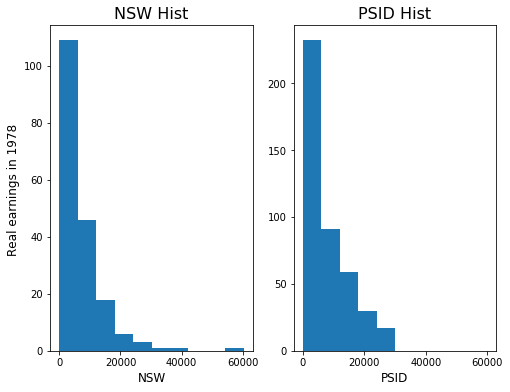

In [9]:
plt.figure(figsize=(8, 6)) 

plt.subplot(1, 2, 1)
histNSW = plt.hist(NSW.tolist())
plt.title('NSW Hist',fontsize=16)
plt.ylabel('Real earnings in 1978 ',fontsize=12)
plt.xlabel('NSW',fontsize=12)

plt.subplot(1, 2, 2)
histPSID = plt.hist(PSID.tolist(), range = [0,60000])
plt.title('PSID Hist',fontsize=16)
plt.xlabel('PSID',fontsize=12)


plt.show()

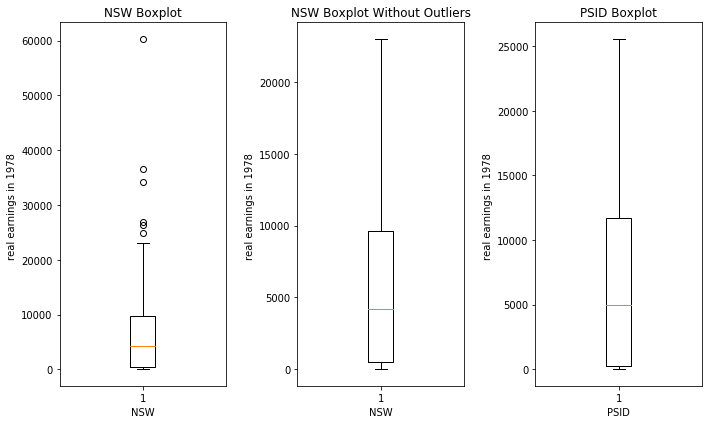

In [10]:
# multiple box plots on one figure
plt.figure(figsize=(10, 6)) 
plt.subplot(131)
plt.boxplot(NSW.tolist())
plt.title('NSW Boxplot')
plt.ylabel('real earnings in 1978 ')
plt.xlabel('NSW')


plt.subplot(132)
plt.boxplot(NSW.tolist(),0,'')
plt.title('NSW Boxplot Without Outliers')
plt.ylabel('real earnings in 1978 ')
plt.xlabel('NSW')


plt.subplot(133)
plt.boxplot(PSID.tolist())
plt.title('PSID Boxplot')
plt.ylabel('real earnings in 1978 ')
plt.xlabel('PSID')


plt.tight_layout()
plt.show()

At first sight, we could say that both histograms and  box plot are very similar. The only difference is that the NSW data have some outliers. However, it's highly possible that those outliers play an important role. As seen in the lecture, some distributions are all about the “outliers”.

We will explore otherways to express those distributions that have a big tail.

#### 2. A closer look at the data

In [11]:
#Selecting Black people that follow the training or not
blackNSW = dataset.loc[dataset['treat'] == 1]['black'] 
blackPSID = dataset.loc[dataset['treat'] == 0]['black']

#Selecting Black people that follow the training or not
whiteNSW = dataset.loc[dataset['treat'] == 1]['white'] 
whitePSID = dataset.loc[dataset['treat'] == 0]['white'] 

#Selecting Hispanic people that follow the training or not
hispanNSW = dataset.loc[dataset['treat'] == 1]['hispan'] 
hispanPSID = dataset.loc[dataset['treat'] == 0]['hispan']

#Selecting married people that follow the training or not
marriedNSW = dataset.loc[dataset['treat'] == 1]['married'] 
marriedPSID = dataset.loc[dataset['treat'] == 0]['married']

In [12]:
#Percentage of black people in that followed the training
blackNSWPer = round(blackNSW[blackNSW == 1].size / blackNSW.size * 100)
#Percentage of black people in that didn't followed the training
blackPSIDPer = round(blackPSID[blackPSID == 1].size / blackPSID.size * 100)

#Percentage of black people in that followed the training
whiteNSWPer = round(whiteNSW[whiteNSW == 1].size / whiteNSW.size * 100)
#Percentage of black people in that didn't followed the training
whitePSIDPer = round(whitePSID[whitePSID == 1].size / whitePSID.size * 100)

#Percentage of hispanic people in that followed the training
hispanNSWPer = round(hispanNSW[hispanNSW == 1].size / hispanNSW.size * 100)
#Percentage of hispanic people in that didn't followed the training
hispanPSIDPer = round(hispanPSID[hispanPSID == 1].size / hispanPSID.size * 100)

#Percentage of married people in that followed the training
marriedNSWPer = round(marriedNSW[marriedNSW == 1].size / marriedNSW.size * 100)
#Percentage of married people in that didn't followed the training
marriedPSIDPer = round(marriedPSID[marriedPSID == 1].size / marriedPSID.size * 100)

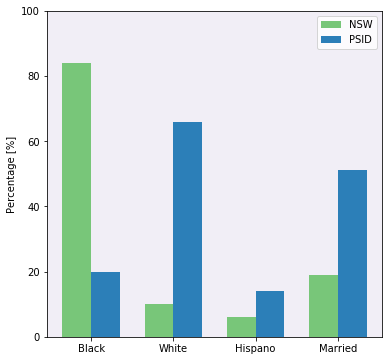

In [13]:
import numpy as np
import matplotlib.pyplot as plt

N = 4
NSWBar = (blackNSWPer,whiteNSWPer, hispanNSWPer, marriedNSWPer)
PSIDBar = (blackPSIDPer,whitePSIDPer, hispanPSIDPer, marriedPSIDPer)

ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()
fig.set_figheight(6)
rects1 = ax.bar(ind, NSWBar, width, color='#78c679')

rects2 = ax.bar(ind + width, PSIDBar, width, color='#2c7fb8')

# add some text for labels, title and axes ticks
ax.set_facecolor('#f1eef6')
ax.set_ylabel('Percentage [%]')
ax.set_ylim(0, 100)
#ax.set_title('Percentage ')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('Black','White' ,'Hispano', 'Married'))

ax.legend((rects1[0], rects2[0]), ('NSW', 'PSID'))


plt.show()

This distribution of the subject it's very interesting. Indeed, we can see that black people, are the large majority of the selected people to participate in the training, while white people where manly refused to participate in the study. This disproportion must be taken in count for further analysis of the results of the study.

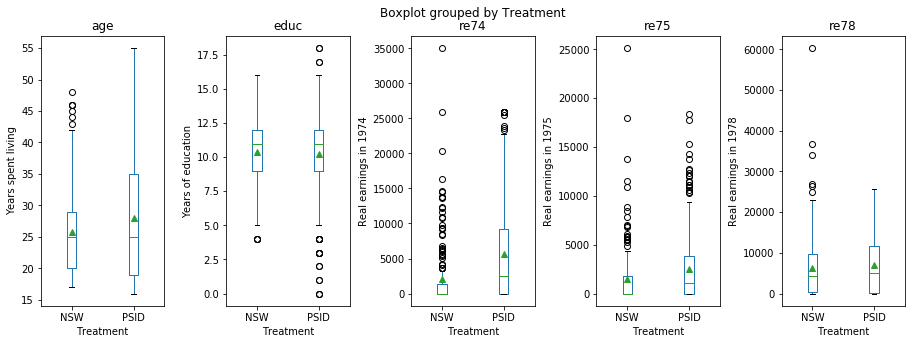

In [14]:
#Making plots
DataFrameBoxPlots(dataset)

#### 3. A propensity score model

In [15]:
logistic = linear_model.LogisticRegression()

X = dataset[['age','educ','black','hispan','married','nodegree','re74','re75','white']] 
Y = dataset.treat


logistic.fit(X ,Y)
# The returned estimates for all classes are ordered by the label of classes.
PropensityScore = pd.DataFrame(logistic.predict_proba(X))

PropensityScore.columns = ['prop score PSID', 'prop score NSW']
PropensityScore['treat'] = dataset['treat']
display(PropensityScore.head(5))

NSWProp = PropensityScore.loc[PropensityScore['treat'] == 1]
PSIDProp = PropensityScore.loc[PropensityScore['treat'] == 0]


,prop score PSID,prop score NSW,treat
0,0.487237,0.512763,1
1,0.706139,0.293861,1
2,0.351450,0.648550,1
3,0.332523,0.667477,1
4,0.336496,0.663504,1


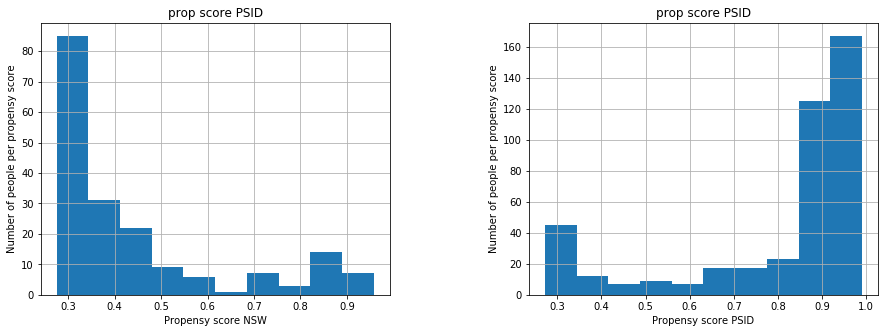

In [16]:
#CHANGE TITLES OF GRAPHS
fig, axs = plt.subplots(1,2,gridspec_kw =  dict(wspace=0.4), figsize=(15,5))

axs[0].set_ylabel('Number of people per propensy score')
axs[0].set_xlabel('Propensy score NSW')

axs[1].set_ylabel('Number of people per propensy score')
axs[1].set_xlabel('Propensy score PSID')

NSWProp.hist(column = ['prop score PSID'], ax=axs[0])
PSIDProp.hist(column = ['prop score PSID'],ax=axs[1])
plt.show()

The model seems to capture some underlying information: people belonging to the PSID have actually some commun attributes that can characterise them.
Our goal is now to balance the data set such that in inter group people have same attributs.

#### 4. Balancing the dataset via matching

In [17]:
import networkx as nx

groupNS=PropensityScore[PropensityScore['treat']==1]
groupPS=PropensityScore[PropensityScore['treat']==0]

Create a graph connecting individuals from control to test group with weight 1/difference in propocency score.

In [18]:
G = nx.Graph() 
weight=[]
for i in groupNS.index:
    for j in groupPS.index:
        veci=np.array([groupNS.loc[i]['prop score PSID'],groupNS.loc[i]['prop score NSW']])
        vecj=np.array([groupPS.loc[j]['prop score PSID'],groupPS.loc[j]['prop score NSW']])
        if np.linalg.norm(veci-vecj)==0:
            G.add_edge(i, j, weight=100000000)
        else:
            G.add_edge(i, j, weight=1/np.linalg.norm(veci-vecj))

In [19]:
#find the graph with only one edge between a elem of one group to the other by taking the biggest weights (means smallest distance)
# It will reduce the actual number of nodes to the size of the smallest group.
A=nx.max_weight_matching(G)


In [20]:
# Here we want to quantify how much matches there are whitin different 'race'
count = 0
for i in range(185):
    NSWrace = []
    PSIrace = []
    NSWrace.append([dataset.loc[i]['white'], dataset.loc[i]['black'],dataset.loc[i]['hispan']])    
    PSIrace.append([dataset.loc[int(A[i])]['white'],dataset.loc[int(A[i])]['black'],dataset.loc[int(A[i])]['hispan']])                   
    if not (np.array_equal(NSWrace,PSIrace)):
            count += 1

In [21]:
a=np.sort(list(A.keys()))
a1=a[0:185]
a2=a[185:185+185]

In [22]:
distance=[]
for i in range(185):
    distance.append(1/(G[i][A[i]]['weight']))
MatchedPS=groupPS.loc[a2]
MatchedPS['IndividualPS'] =MatchedPS.index
MatchedPS.set_index(np.array(range(185)),inplace=True)
MatchedPS.rename(columns={'prop score no PSID': 'Prob PS (0)', 'prop score no NSW': 'Prob NS (0)'}, inplace=True)

MatchedNS=groupNS.loc[a1]
MatchedNS['IndividualNS'] =MatchedNS.index
MatchedNS.rename(columns={'prop score no PSID': 'Prob PS (1)', 'prop score no NSW': 'Prob NS (1)'}, inplace=True)


Matching=pd.concat([MatchedNS,MatchedPS],axis=1)
Matching['distance']=distance
Matching['distance'].min()

1e-08

In [23]:
data_matched=dataset.loc[list(a1)+list(a2)]
data_matched.head()

,Treatment,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,white
0,NSW,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0
1,NSW,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0
2,NSW,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0
3,NSW,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0
4,NSW,1,33,8,1,0,0,1,0.0,0.0,289.7899,0


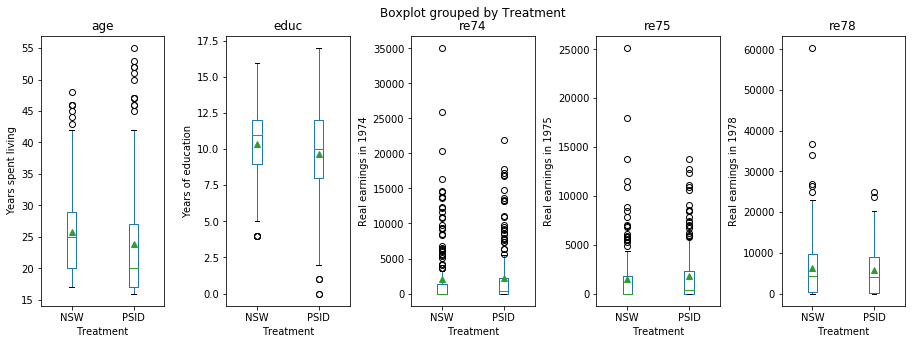

In [24]:
DataFrameBoxPlots(data_matched)

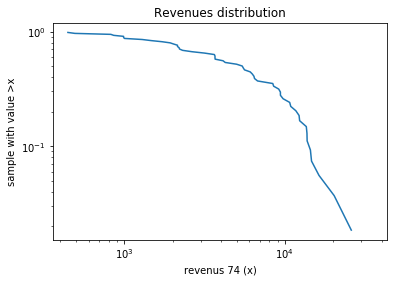

In [25]:
data=np.array(data_matched.loc[0:184]['re74'])
data2=np.array(data_matched.loc[184:184+185]['re74'])
##ccdf plot:
s_data=np.sort(data[data!=0 ])
plt.loglog(s_data,np.array((range(len(s_data))))[::-1]/len(s_data))
plt.ylabel("sample with value >x")
plt.xlabel("revenus 74 (x)")
plt.title('Revenues distribution')
plt.show()

In [26]:
#Finding percentages for given group
def get_fraction_bin(data_matching):
    nr_of_rows = data_matching.shape[0]
    nr_of_black = data_matching['black'].value_counts()
    nr_of_hisp = data_matching['hispan'].value_counts()
    nr_of_white = data_matching['white'].value_counts()
    nr_of_married = data_matching['married'].value_counts()
    nr_of_nodegree = data_matching['nodegree'].value_counts()
    count_bin = [nr_of_black, nr_of_hisp,nr_of_white, nr_of_married, nr_of_nodegree]
    values = []
    for element in count_bin:
        if(len(element) == 2):
            values.append(element[1] / nr_of_rows)
        else:
            values.append(0)
    return values

In [27]:
matched_NSW=data_matched[data_matched['treat']==1]
matched_PS=data_matched[data_matched['treat']==0]

NSW_black, NSW_hispanic, NSW_white, NSW_married, NSW_nodegree=get_fraction_bin(matched_NSW)
PS_black, PS_hispanic,PS_white, PS_married, PS_nodegree=get_fraction_bin(matched_PS)


,categories,NSW,PSID
0,Black,0.843243,0.470270
1,Hispanic,0.059459,0.254054
2,White,0.097297,0.275676
3,Married,0.189189,0.243243
4,No degree,0.708108,0.713514


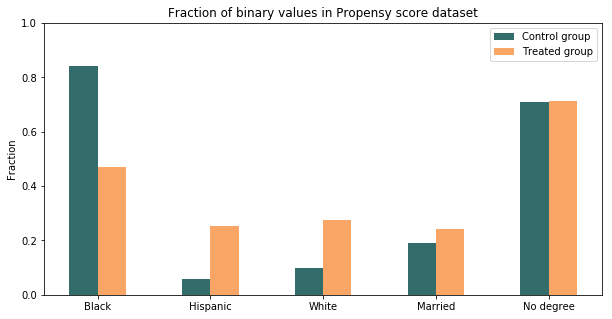

In [39]:
data = {
    'categories':['Black', 'Hispanic','White', 'Married', 'No degree'],
    'NSW': [NSW_black,  NSW_hispanic,NSW_white, NSW_married, NSW_nodegree],
    'PSID': [PS_black, PS_hispanic,PS_white, PS_married, PS_nodegree]
}

count_df = pd.DataFrame(data, columns = ['categories', 'NSW', 'PSID'])
display(count_df)

# bars position
pos = list(range(len(count_df['NSW']))) 
width = 0.25 

fig, ax = plt.subplots(figsize=(10,5))
plt.bar(pos, count_df['NSW'], width, alpha=0.8, color='#004946')
plt.bar([ p + width for p in pos ], count_df['PSID'], width, alpha=0.8,color='#F78F3F')
        
# chart title
ax.set_title('Fraction of binary values in Propensy score dataset')

# pos bar
ax.set_xticks([p + 0.5 * width for p in pos])
ax.set_ylabel('Fraction')
ax.set_xticklabels(count_df['categories'])

plt.ylim([0, 1])

plt.legend(['Control group', 'Treated group'], loc='upper right')
plt.grid(color='w', linestyle=' ')
plt.show()

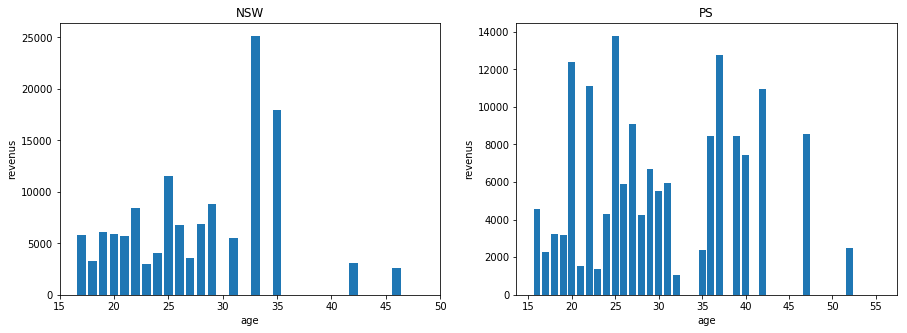

In [29]:
age, revenues = zip(*sorted(zip(matched_NSW['age'].values, matched_NSW['re75'].values)))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.bar(age,revenues)
ax1.set_xlabel('age')
ax1.set_ylabel('revenus')
ax1.set_title('NSW')

age, revenues = zip(*sorted(zip(matched_PS['age'].values, matched_PS['re75'].values)))
ax2.bar(age,revenues)
ax2.set_xlabel('age')
ax2.set_ylabel('revenus')
ax2.set_title('PS')
plt.show()

The goal here is to reduc the variance of a feature among the TWO categories. More precisely we would like to increase the overlap of the two respective distributions.
This can be observed using the box plot or bins graph. The box plot is harder to read for a novice but gives a lot of information for the veteran.
- The age distribution looks better than before the upper quartile are closer. 
- The educ distrib are seem, looking at the min and max, worse. Looking at the quartile we see that indeed the distrib before the matching was better. 
- The distrib for the earning are full of outliers and are harder to compare

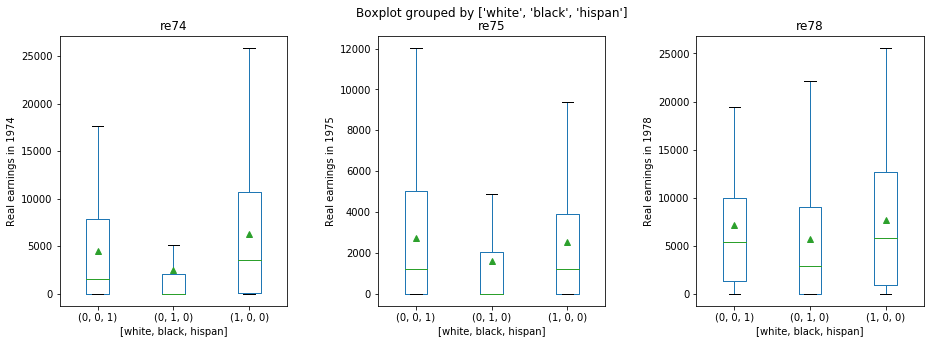

In [40]:
fig, axs = plt.subplots(1,3,gridspec_kw =  dict(wspace=0.4), figsize=(15,5))
fig.subplots_adjust(wspace=1)
#fig.suptitle('New title here')

fig.texts = [] #flush the old super titles
axs[0].get_figure().suptitle("")
#plt.suptitle('Some title')

axs[0].set_ylabel('Real earnings in 1974')
axs[1].set_ylabel('Real earnings in 1975')
axs[2].set_ylabel('Real earnings in 1978')

dataset.boxplot(column='re74',  by=['white','black','hispan'], ax=axs[0],grid = False, showfliers=False, showmeans=True)
dataset.boxplot(column='re75', by=['white','black','hispan'], ax=axs[1],grid = False, showfliers=False, showmeans=True)
dataset.boxplot(column='re78', by=['white','black','hispan'], ax=axs[2],grid = False, showfliers=False, showmeans=True)
plt.show()

In [41]:
whiteDf = dataset.loc[dataset['white'] == 1]
whiteDF = whiteDf.drop(['white','black','hispan'],1)
whiteDf = whiteDf.reset_index(drop=True)

blackDf = dataset.loc[dataset['black'] == 1]
blackDF = blackDf.drop(['white','black','hispan'],1)
blackDf = dataset.reset_index(drop=True)

hispanDf = dataset.loc[dataset['hispan'] == 1]
hispanDf = hispanDf.drop(['white','black','hispan'],1)
hispanDf = hispanDf.reset_index(drop=True)

White people matching 

In [42]:
whitePropScore = propensityScoreDf(whiteDf)
MatchingW, a1, a2 = matchingPeople(whitePropScore)
white_matched = whiteDf.loc[list(a1)+list(a2)]


Black people matching 

In [43]:
blackPropScore = propensityScoreDf(blackDf)
MatchingB, a1, a2 = matchingPeople(blackPropScore)
black_matched = blackDf.loc[list(a1)+list(a2)]


In [44]:
hispanPropScore = propensityScoreDf(hispanDf)
MatchingH, a1, a2 = matchingPeople(hispanPropScore)
hispan_matched = hispanDf.loc[list(a1)+list(a2)]

In [45]:
all_matched = white_matched.append(black_matched, ignore_index=False, verify_integrity=False)
all_matched = all_matched.append(hispan_matched, ignore_index=False, verify_integrity=False)

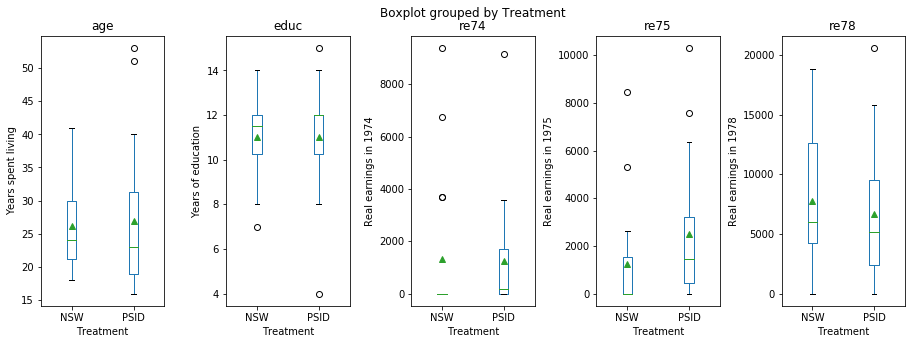

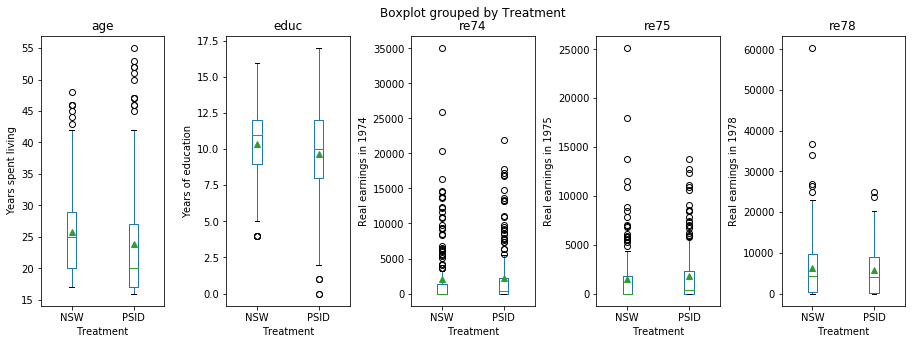

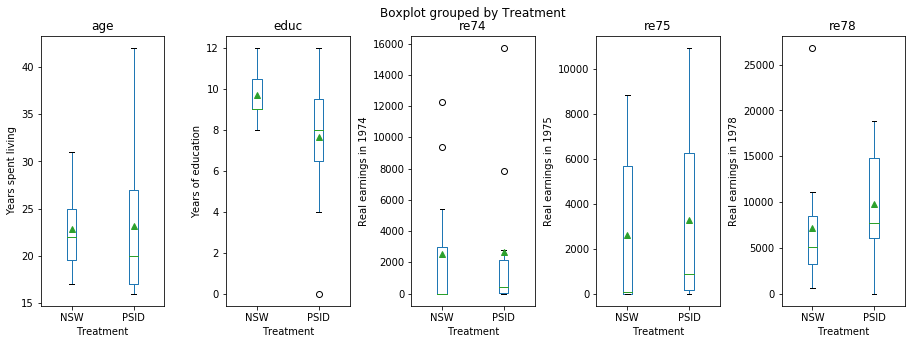

In [46]:
DataFrameBoxPlots(white_matched)
DataFrameBoxPlots(black_matched)
DataFrameBoxPlots(hispan_matched)


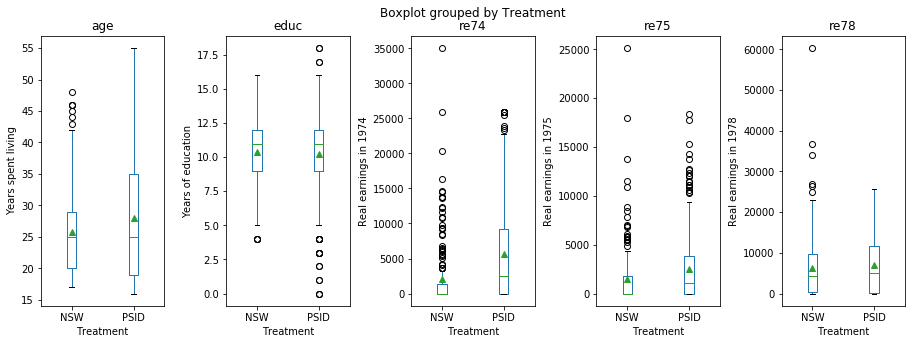

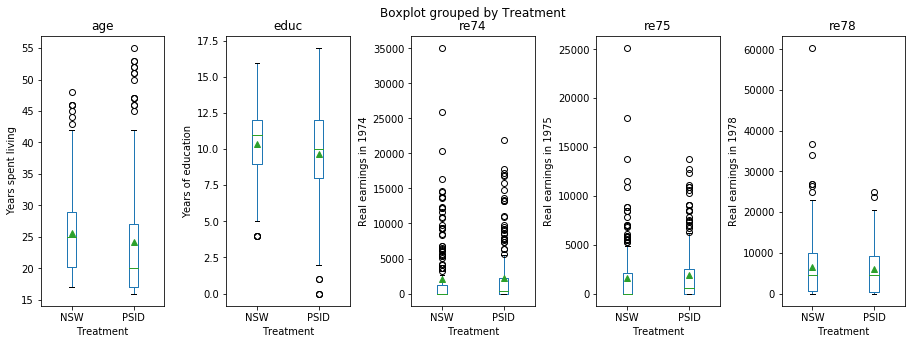

In [47]:
DataFrameBoxPlots(dataset)
DataFrameBoxPlots(all_matched)

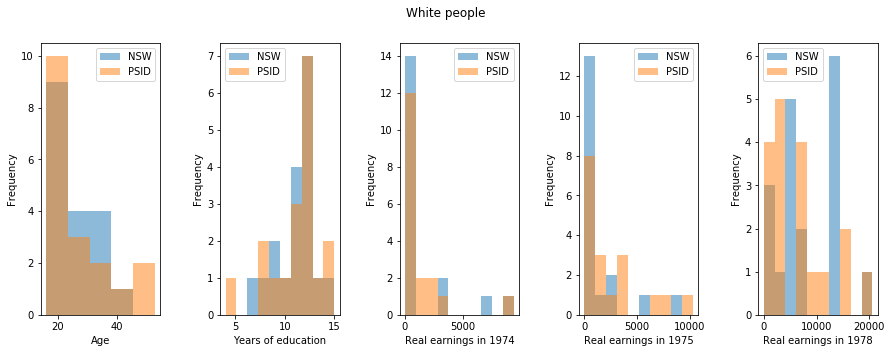

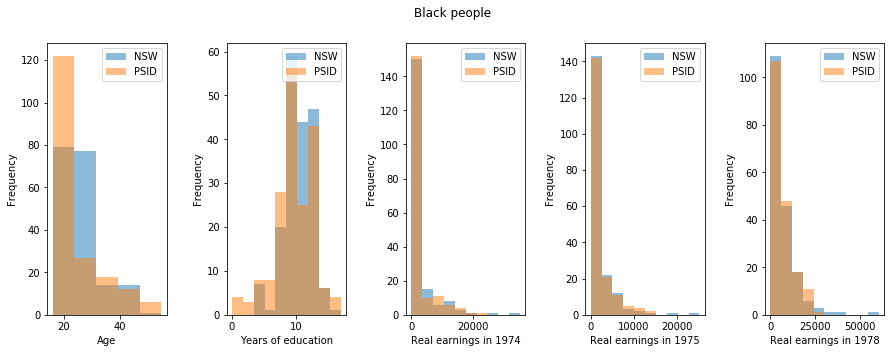

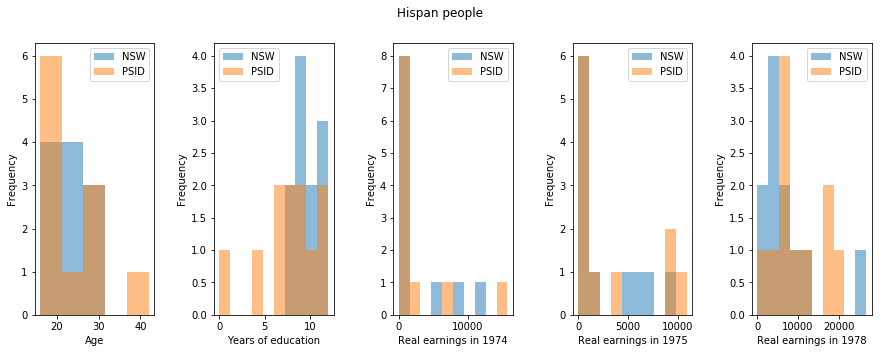

In [48]:
DataFrameHistogram(white_matched,'White people')
DataFrameHistogram(black_matched,'Black people')
DataFrameHistogram(hispan_matched,'Hispan people')

#### 5. Balancing the groups further

#### 6. A less naive analysis

## Question 2: Applied ML